# K-Means Clustering - Step by Step Implementation

## Overview

This Jupyter Notebook shows a custom implementation of the K-Means clustering algorithm, applied to the Boston housing dataset. The purpose is to uncover and understand the internal mechanisms of the K-Means clustering process by developing it from scratch and applying it to real-world data. The Boston housing dataset consists of various housing metrics collected by the U.S. Census Service.

## Goals

The primary objective of this analysis is understanding the background workings of the K-Means clustering algorithm by:

- Implementing the algorithm step-by-step.
- Investigating how different initialization strategies influence the results.
- Clustering neighborhoods based on their features to identify patterns in the housing data.

## Methodology

- Data Loading and Preprocessing: Start by loading the Boston housing dataset, apply transformations to normalize and standardize the data, making it suitable for clustering.

- Centroid Initialization: Explore two centroid initialization methods—random and the farthest point strategy. These methods will help demonstrate the impact of centroid placement on clustering outcomes.

- Detailed K-Means Implementation: Manually implement the K-Means algorithm, including functions for assigning data points to the nearest cluster, updating centroid positions, and evaluating convergence.

- Cluster Evaluation and Insights: Analyze and visualize the resulting clusters to interpret how well they capture the inherent structures within the data.

## Structure of the Notebook

- Dataset Introduction and Preprocessing: We introduce the dataset and conduct preprocessing tasks.

- Custom K-Means Implementation: This section walks through the custom implementation of the K-Means algorithm, focusing on the core functions that drive the clustering process.

- Visualization and Analysis of Results: Finally, we visualize the clustering outcomes and discuss the effectiveness and characteristics of the clusters formed.

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Data loading

data_path = 'boston.csv'
data = pd.read_csv(data_path)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
# Exploratory data analysis

# Summary statistics
print("\nSummary Statistics:")
print(data.describe())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())



Summary Statistics:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std   


Visualizing the distribution of features...


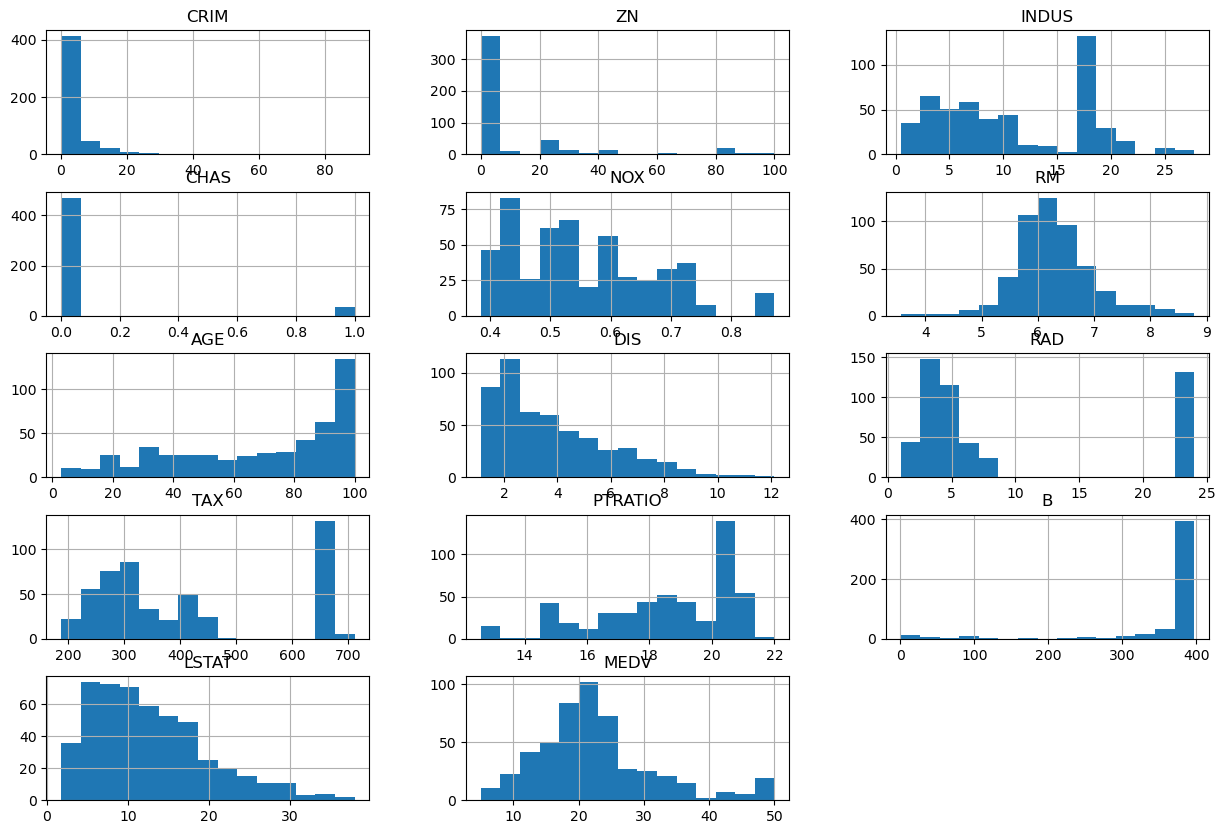

In [4]:
# Distribution of features
print("\nVisualizing the distribution of features...")
data.hist(bins=15, figsize=(15, 10), layout=(5, 3));


Correlation Matrix:


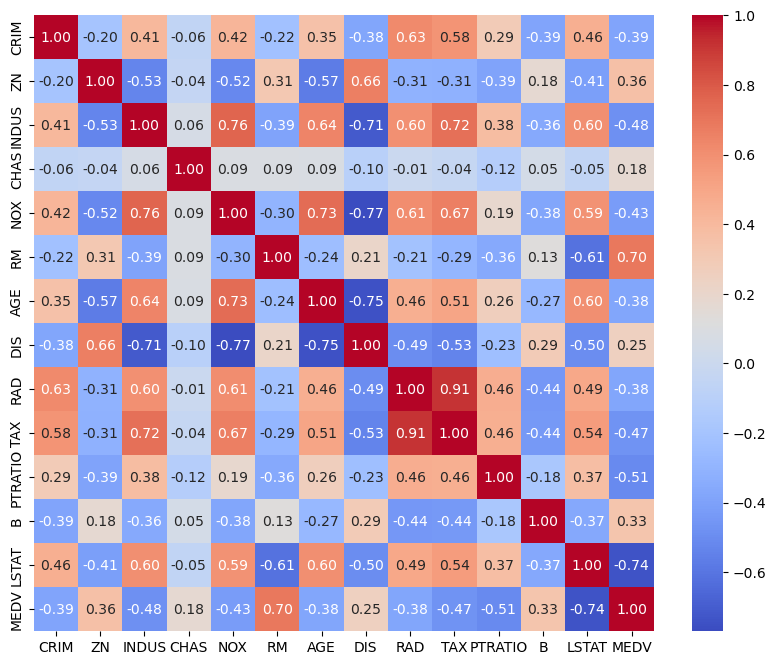

In [5]:
# Correlation matrix
print("\nCorrelation Matrix:")
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

### EDA Summary
#### Distributions:

- Crime Rate (CRIM): Right-skewed; low rates are most common.
- Zoning (ZN): Most areas are not zoned for large homes.
- Room Count (RM): Nearly normal; around 6 rooms per house.

#### Correlations:

- Industrial & Pollution (INDUS-NOX): Positively correlated.
- Distance & Pollution (DIS-NOX): Inversely related.
- Status & Value (LSTAT-MEDV): Lower economic status aligns with lower house values.
- Rooms & Value (RM-MEDV): More rooms generally mean higher house prices.

In [6]:
# Data Cleaning

# Apply logarithmic transformation to right-skewed features
skewed_features = ['CRIM', 'ZN', 'DIS', 'LSTAT']
data[skewed_features] = data[skewed_features].apply(lambda x: np.log1p(x))

# Identify and handle outliers
for feature in skewed_features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[feature] >= (Q1 - 1.5 * IQR)) & (data[feature] <= (Q3 + 1.5 * IQR))]

# Standardize the features
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [7]:
# Dimensionality reduction
threshold = 0.7

# Identify features that are highly correlated
high_corrs = (corr_matrix.abs() > threshold).sum() - 1  # Subtract 1 to ignore self-correlation
redundant_features = high_corrs[high_corrs > 0]

print(f"Number of features with correlation higher than {threshold}: {len(redundant_features)}")
print(f"These features might be candidates for reduction: {redundant_features.index.tolist()}")

# The number of components for PCA could be the total features minus the redundant ones
n_components_choice = data_scaled.shape[1] - len(redundant_features)

print(f"Suggested number of components for PCA based on redundancy: {n_components_choice}")


Number of features with correlation higher than 0.7: 8
These features might be candidates for reduction: ['INDUS', 'NOX', 'AGE', 'DIS', 'RAD', 'TAX', 'LSTAT', 'MEDV']
Suggested number of components for PCA based on redundancy: 6


In [8]:
# PCA

# Apply PCA with 6 components
pca = PCA(n_components=6)
data_reduced = pca.fit_transform(data_scaled)

# Check the explained variance ratio of the 6 components
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

print("Explained variance by each component:", explained_variance)
print("Cumulative explained variance:", cumulative_explained_variance)


Explained variance by each component: [0.50020694 0.12294267 0.09385001 0.06205027 0.06117337 0.04799077]
Cumulative explained variance: [0.50020694 0.62314961 0.71699962 0.77904989 0.84022326 0.88821403]


In [9]:
data_reduced

array([[ 2.51297263,  0.38996726,  0.16982281,  1.10879127, -0.18509244,
        -0.56875487],
       [ 1.43032794, -0.61701303,  0.90498666, -0.02046182, -0.56083581,
         0.51192301],
       [ 2.55936372,  0.91610909,  0.25470371, -0.62973776, -1.11825026,
         0.83209536],
       ...,
       [ 0.4473829 ,  0.44001076,  1.09239585, -0.99717027, -1.48764598,
         0.96069672],
       [ 0.3240198 ,  0.09765477,  1.09433551, -0.89383987, -1.30245152,
         0.91699707],
       [-0.11852665, -1.16453162,  1.29225527, -0.62430357, -0.73912122,
         0.65117072]])

In [10]:
data_df = pd.DataFrame(data_reduced, columns=[f'PC{i+1}' for i in range(data_reduced.shape[1])])
data_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,2.512973,0.389967,0.169823,1.108791,-0.185092,-0.568755
1,1.430328,-0.617013,0.904987,-0.020462,-0.560836,0.511923
2,2.559364,0.916109,0.254704,-0.629738,-1.118250,0.832095
3,3.072003,0.443910,-0.197886,-1.049471,-0.899038,0.971472
4,2.833373,0.485608,-0.019283,-0.910866,-0.949578,0.945435


In [11]:
# K-means custom implementation

def initialize_centroids(data, k, method='random'):
    """
    Initialize centroids for K-means clustering.
    
    Parameters:
        data (DataFrame): The dataset from which centroids are to be initialized.
        k (int): The number of clusters to form, which also defines the number of centroids.
        method (str, optional): Method to initialize the centroids. Options are 'random' and 'farthest'.
            'random' selects 'k' random points from the dataset.
            'farthest' selects the first point randomly, then each subsequent point is the one farthest from the existing centroids.
    
    Returns:
        ndarray: An array of 'k' centroids initialized according to the specified method.
    
    """
    if method == 'random':
        return data.sample(n=k).values
    elif method == 'farthest':
        centroids = [data.iloc[np.random.randint(0, len(data))].values]
        for _ in range(1, k):
            distances = np.min(cdist(data, np.array(centroids), 'euclidean'), axis=1)
            farthest = np.argmax(distances)
            centroids.append(data.iloc[farthest].values)
        return np.array(centroids)
    else:
        raise ValueError("Unsupported initialization method")

def assign_clusters(data, centroids):
    """
    Assign data points to the nearest centroid.
    
    Parameters:
        data (DataFrame): The dataset where each row is a data point.
        centroids (ndarray): Current centroids to which data points are assigned.
    
    Returns:
        ndarray: An array of indices indicating the cluster assignment for each data point.
    
    """
    distances = cdist(data, centroids, 'euclidean')
    return np.argmin(distances, axis=1)

def update_centroids(data, labels, k):
    """
    Update centroid positions based on current cluster assignments.
    
    Parameters:
        data (DataFrame): The dataset where each row is a data point.
        labels (ndarray): Array of cluster assignments for each data point.
        k (int): The number of clusters.
    
    Returns:
        ndarray: An array containing the updated positions of the centroids.
    
    """
    new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

def kmeans(data, k, max_iter=100, tol=1e-4, method="random"):
    """
    Perform K-means clustering on a dataset.
    
    Parameters:
        data (DataFrame or ndarray): The dataset on which to perform clustering.
        k (int): The number of clusters to form.
        max_iter (int, optional): The maximum number of iterations to perform.
        tol (float, optional): Tolerance for convergence. If the change in centroid position is less than this value, the algorithm stops.
        method (str, optional): Method to use for initializing centroids. Defaults to 'random'.
    
    Returns:
        tuple: A tuple containing:
            - centroids (ndarray): The final positions of the centroids.
            - labels (ndarray): Cluster assignments for each data point in the dataset.
    
    """
    centroids = initialize_centroids(data, k, method=method)
    for iteration in range(max_iter):
        labels = assign_clusters(data, centroids)
        new_centroids = update_centroids(data, labels, k)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    return centroids, labels


In [12]:
centroids, labels = kmeans(data_df, k=3, method='random')

In [13]:
centroids

array([[-3.45024599,  0.38523603, -0.53145563, -0.00697126,  0.15399595,
        -0.2259827 ],
       [ 0.31354996, -0.63986854,  0.87101543, -0.12987334, -0.14792021,
         0.31226174],
       [ 2.83095135,  0.4181113 , -0.56258204,  0.16413396,  0.0362088 ,
        -0.16868602]])

In [14]:
labels

array([2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,

### Comparing different methods of centroid initialization
The Within-Cluster Sum of Squares (WCSS) is a measure of the total squared distance between each point within a cluster and the centroid of that cluster, indicating the compactness of the clusters. A lower WCSS value suggests better clustering performance as it indicates tighter and more defined clusters.

In [15]:
def calculate_wcss(data, centroids, labels):
    # WCSS for a single feature 'CRIM'
    feature_idx = data.columns.get_loc('CRIM')  # Get the index of the 'CRIM' column
    wcss = 0
    for i, centroid in enumerate(centroids):
        # Sum of squared distances for 'CRIM' feature
        wcss += np.sum((data.iloc[labels == i, feature_idx] - centroid[feature_idx]) ** 2)
    return wcss

def evaluate_kmeans(data, k, init_method):
    centroids, labels = kmeans(data, k, method=init_method)
    wcss = calculate_wcss(data, centroids, labels)
    return wcss

wcss_random = evaluate_kmeans(data, k=3, init_method='random')
wcss_farthest = evaluate_kmeans(data, k=3, init_method='farthest')

print(f"Random Initialization - WCSS: {wcss_random}")
print(f"Farthest Initialization - WCSS: {wcss_farthest}")

Random Initialization - WCSS: 96.82726073840566
Farthest Initialization - WCSS: 96.82726073840566


# Model Evaluation

In [16]:
# In this step we reduce the dimensionality of the dataset to 3 features so we can visualize the clusters

def plot_kmeans_clusters(data, k, init_method):
    # Dimensionality reduction to 3D
    pca = PCA(n_components=3)
    data_3d = pca.fit_transform(data)
    data_3d_df = pd.DataFrame(data_3d, columns=[f'PC{i+1}' for i in range(data_3d.shape[1])])

    # Apply k-means clustering to the reduced data
    centroids, labels = kmeans(data_3d_df, k=k, method=init_method)

    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each cluster with a different color
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_data = data_3d[labels == label]
        ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2], 
                   label=f'Cluster {label}', cmap='viridis', alpha=0.5)

    # Plot centroids with a higher zorder to ensure visibility
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
               c='red', marker='x', s=200, label='Centroids', depthshade=False)

    # Labeling
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(f'Cluster Visualization: {k} Clusters, {init_method} Initialization')

    # Adding a legend with a title
    ax.legend(title="Legend")

    # Show plot
    plt.show()

C:\Users\Jovana\AppData\Local\Temp\ipykernel_6072\1253575478.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],


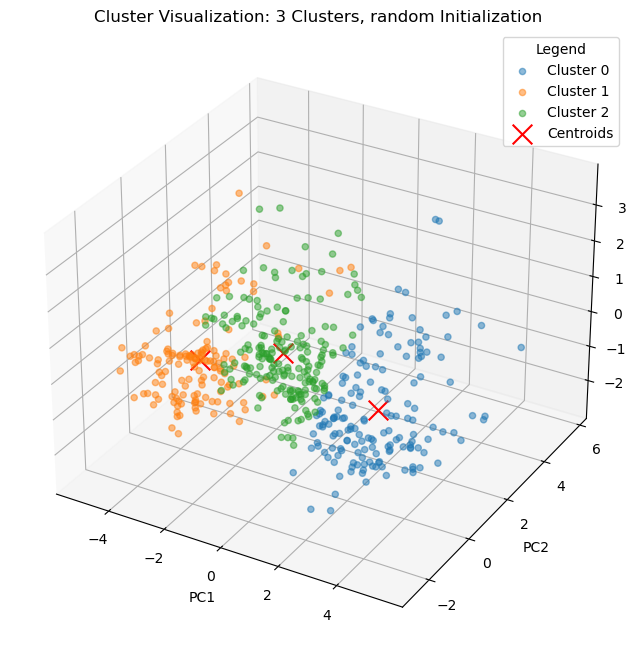

In [17]:
plot_kmeans_clusters(data_scaled, k=3, init_method='random')

C:\Users\Jovana\AppData\Local\Temp\ipykernel_6072\1253575478.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],


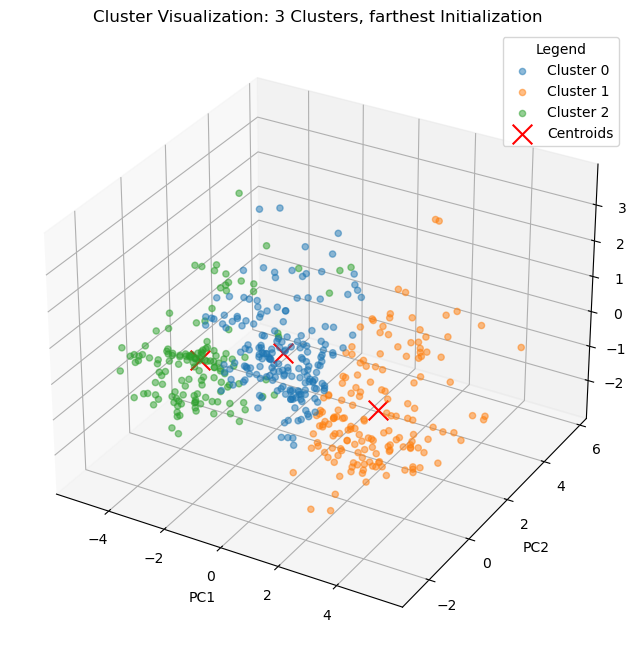

In [18]:
plot_kmeans_clusters(data_scaled, k=3, init_method='farthest')

C:\Users\Jovana\AppData\Local\Temp\ipykernel_6072\1253575478.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],


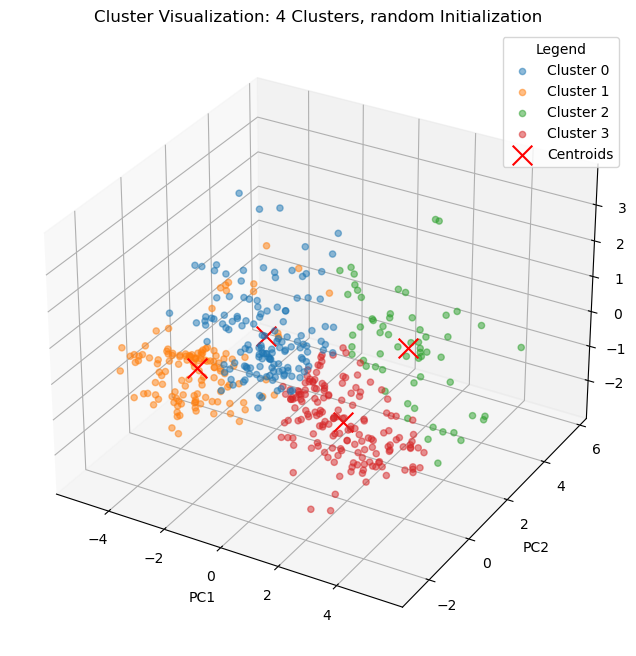

In [19]:
plot_kmeans_clusters(data_scaled, k=4, init_method='random')